In [1]:
import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

/tmp/ipykernel_212869/3005166470.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
xls = pd.ExcelFile('20241119_combined_data.xlsx')


combo = pd.read_excel(xls, '20241119_combined_data',decimal='.')
combo

,Date,Lat,Long,TIMESTAMP,Unnamed: 4,SF6 (fmol/L),Col,Area,TSG_salinity,TSG-temp,Obs_no
0,2024-07-17,64.32825,-21.80205,04:45:00,PM,0.10,R,0.1,33.3366,11.8161,1
1,2024-07-17,64.32976,-21.79768,04:46:00,PM,0.10,L,0.1,33.3808,11.6866,2
2,2024-07-17,64.33173,-21.79222,04:48:00,PM,0.10,R,0.1,33.3917,11.7163,3
3,2024-07-17,64.33325,-21.78762,04:49:00,PM,0.10,L,0.1,33.2175,11.8738,4
4,2024-07-17,64.33526,-21.78227,04:50:00,PM,0.10,R,0.1,33.1928,11.8925,5
...,...,...,...,...,...,...,...,...,...,...,...
2724,2024-07-25,64.29511,-22.05250,06:02:00,PM,3.58,L,1516.6,34.1858,12.9878,2725
2725,2024-07-25,64.29914,-22.06086,06:04:00,PM,6.28,L,2637.9,34.1605,12.9207,2726
2726,2024-07-25,64.30427,-22.06558,06:07:00,PM,4.64,L,1965.5,34.1565,12.9650,2727
2727,2024-07-25,64.30935,-22.07066,06:09:00,PM,4.46,L,1848.6,33.8809,12.9910,2728


In [3]:
obs=xr.Dataset.from_dataframe(combo)
obs=obs.set_index(index=['Date','Obs_no'])
#obs=obs.drop_duplicates('index')
obs=obs.unstack('index')
#obs=obs.rename(name_dict={'mon/day/yr':'time','Depth':'depth','Latitude(¬∞N)':'lat','Longitude(¬∞E)':'lon'})


In [2]:
grid=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/roms_setups/Iceland3_MARBL/1.Make_grid/Iceland4_grd.nc')
mask=roms_regrid(grid,grid['mask_rho'])

In [3]:
grid

<xarray.Dataset> Size: 85MB
Dimensions:       (one: 1, eta_rho: 722, xi_rho: 1442, eta_coarse: 362,
                   xi_coarse: 722)
Dimensions without coordinates: one, eta_rho, xi_rho, eta_coarse, xi_coarse
Data variables: (12/19)
    spherical     (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    angle         (eta_rho, xi_rho) float64 8MB dask.array<chunksize=(722, 1442), meta=np.ndarray>
    h             (eta_rho, xi_rho) float64 8MB dask.array<chunksize=(722, 1442), meta=np.ndarray>
    hraw          (eta_rho, xi_rho) float64 8MB dask.array<chunksize=(722, 1442), meta=np.ndarray>
    f             (eta_rho, xi_rho) float64 8MB dask.array<chunksize=(722, 1442), meta=np.ndarray>
    pm            (eta_rho, xi_rho) float64 8MB dask.array<chunksize=(722, 1442), meta=np.ndarray>
    ...            ...
    xy_flip       (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    lon_coarse    (eta_coarse, xi_coarse) float64 2MB dask.array<chunksize=(362, 722), meta=np.ndarray>
    lat_coarse    (eta_coarse, xi_coarse) float64 2MB dask.array<chunksize=(362, 722), meta=np.ndarray>
    angle_coarse  (eta_coarse, xi_coarse) float64 2MB dask.array<chunksize=(362, 722), meta=np.ndarray>
    h_coarse      (eta_coarse, xi_coarse) float64 2MB dask.array<chunksize=(362, 722), meta=np.ndarray>
    mask_coarse   (eta_coarse, xi_coarse) float64 2MB dask.array<chunksize=(362, 722), meta=np.ndarray>
Attributes:
    Title:    ROMS grid by Easy Grid. Settings: nx: 1440 ny: 720 xsize: 43.6 ...
    Date:     21-Aug-2023
    Type:     ROMS grid produced by Easy Grid

In [4]:
import numpy as np

def get_daily_locations(obs_ds):
    dates = obs_ds['Date'].values
    num_days = len(dates)
    num_obs = obs_ds.dims['Obs_no']
    
    # Initialize empty array: (days, obs, 2)
    locations = np.empty((num_days, num_obs, 2))
    
    for i in range(0,num_days):
        lat = obs_ds['Lat'].isel(Date=i).values
        lon = obs_ds['Long'].isel(Date=i).values + 360  # convert to 0–360 range
        locations[i, :, 0] = lat
        locations[i, :, 1] = lon
    
    return locations

# Example usage
locations_array = get_daily_locations(obs)
print("Shape of locations array:", locations_array.shape)  # should be (9, 2729, 2)


Shape of locations array: (9, 2729, 2)


/tmp/ipykernel_1582087/1794326622.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_obs = obs_ds.dims['Obs_no']


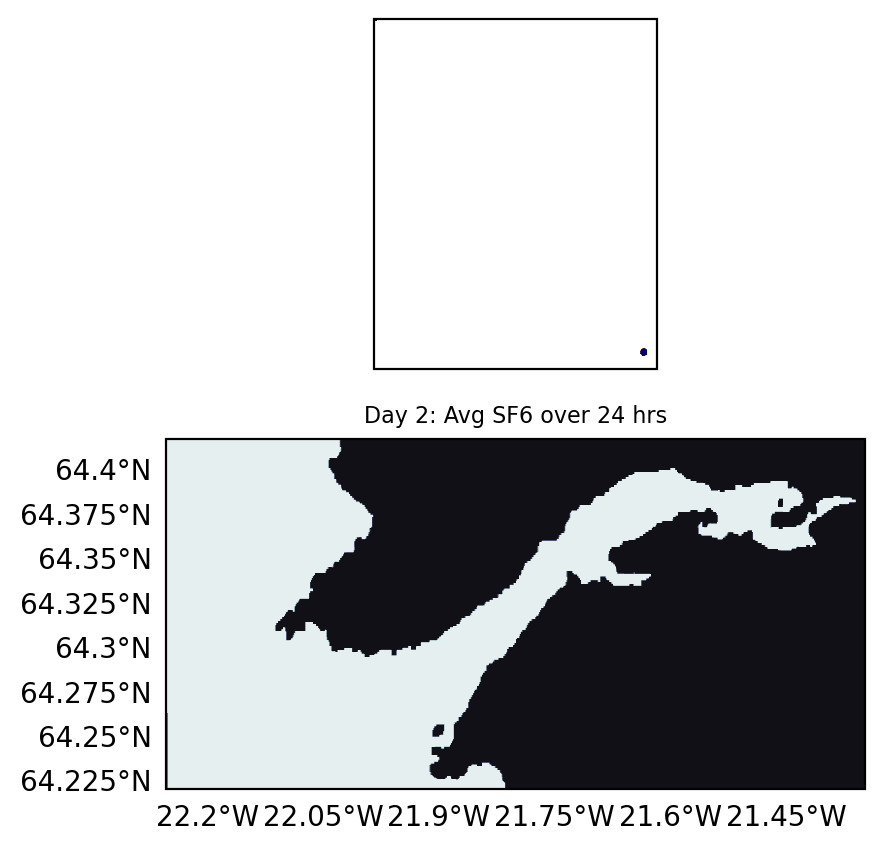

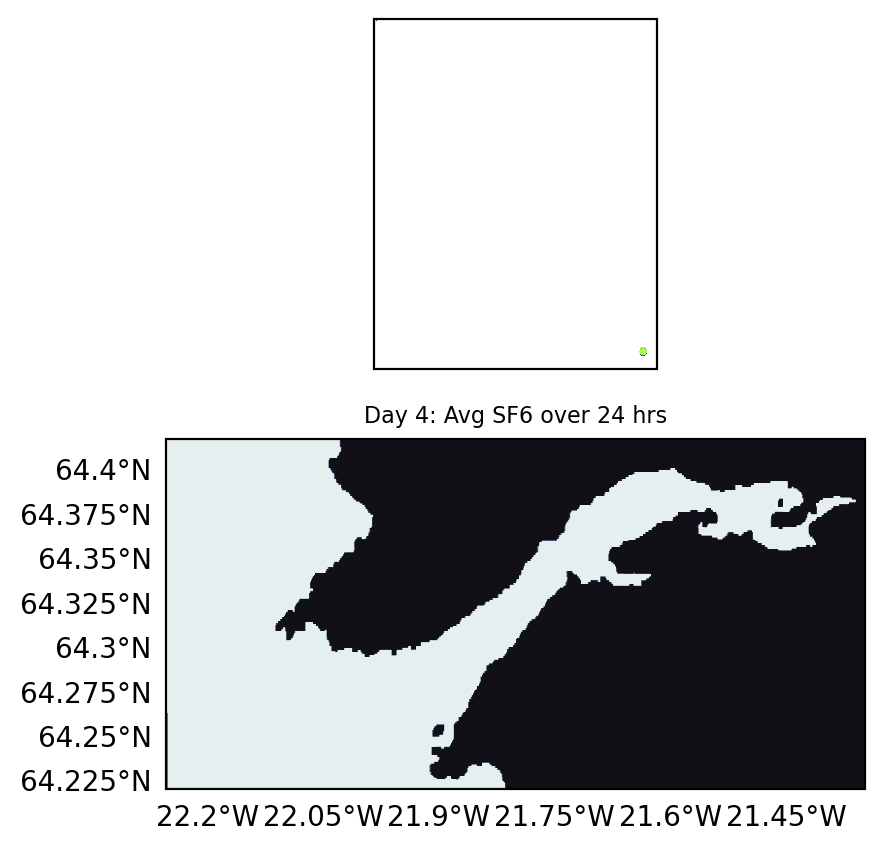

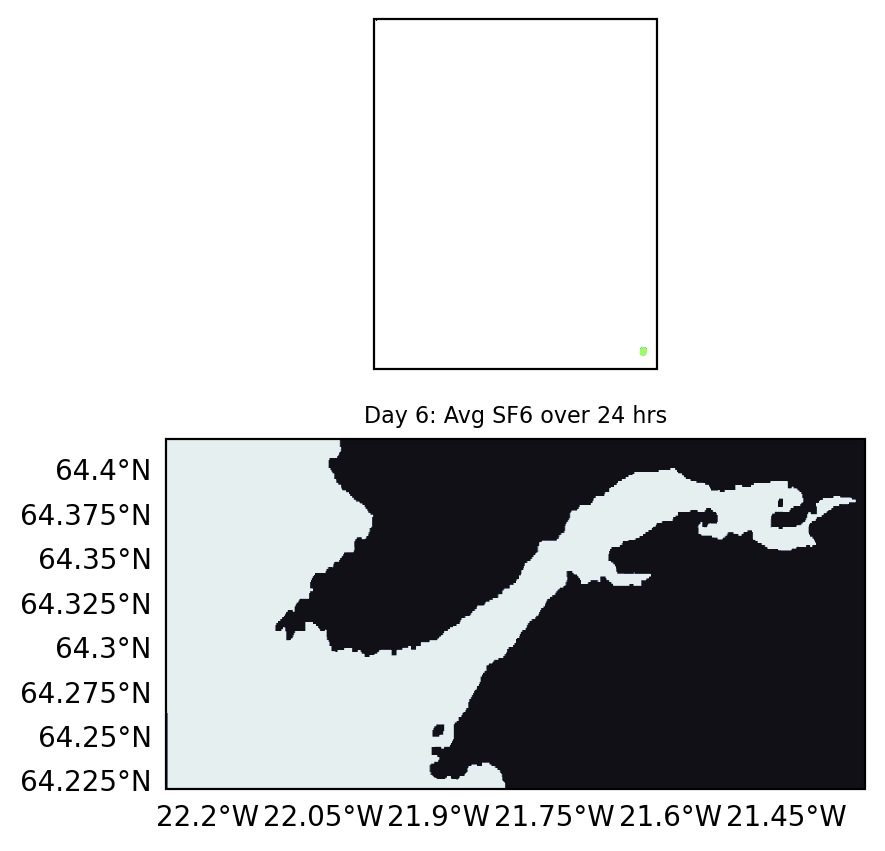

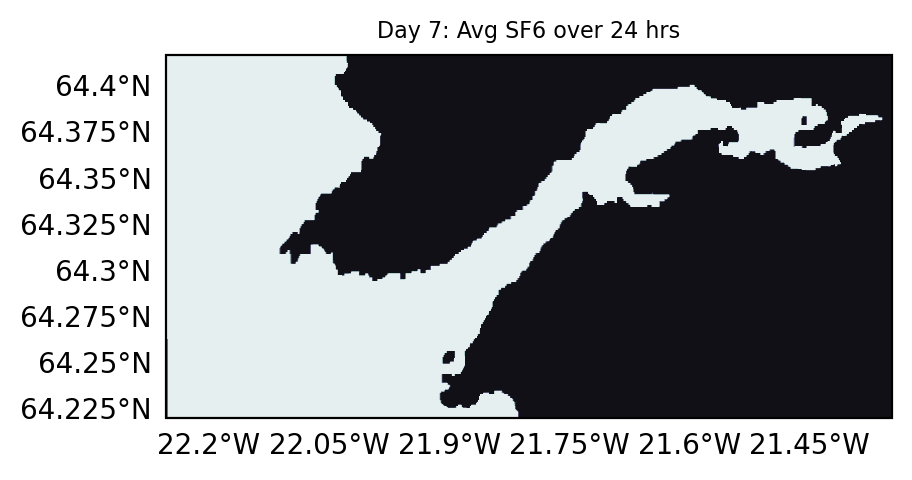

In [13]:
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


figures = [
    {'days': [0, 1]},       # Figure 1: Days 1–2
    {'days': [2, 3]},       # Figure 2: Days 3–4
    {'days': [4, 5]},       # Figure 3: Days 5–6
    {'days': [6]},          # Figure 4: Day 7
]

for fig_idx, group in enumerate(figures):
    nrows = len(group['days'])
    fig, axs = plt.subplots(nrows=nrows, figsize=(6, 2.5 * nrows), dpi=200,
                            subplot_kw={'projection': ccrs.Mercator()})

    if nrows == 1:
        axs = [axs]  # make iterable

    for ax, day in zip(axs, group['days']):
        obs_day=obs['SF6 (fmol/L)'].isel(Date=day).values
        obs_lat=obs['Lat'].isel(Date=day).values
        obs_lon=obs['Long'].isel(Date=day).values
        obs_clear = obs_day[~np.isnan(obs_day)]
        obs_lat = obs_lat[~np.isnan(obs_lat)]
        obs_lon = obs_lon[~np.isnan(obs_lon)]
        
        ax.contourf(mask.lon, mask.lat, mask.load(), transform=ccrs.PlateCarree(), cmap='bone')
        
        scatter = ax.scatter(obs_lat, obs_lon, c=obs_clear, cmap='jet', edgecolor='none',
                             transform=ccrs.PlateCarree(), s=5,
                             norm=LogNorm(vmin=1e-1, vmax=5e4))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.set_title(f'Day {day+1}: Avg SF6 over 24 hrs', fontsize=8)
    # Get the bounding box of the mask
    lon_min = float(mask.lon.min())
    lon_max = float(mask.lon.max())
    lat_min = float(mask.lat.min())
    lat_max = float(mask.lat.max())

    # Set map extent to match mask
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Colorbar
#cbar = ax.colorbar(scatter, ax=axs, orientation='vertical', shrink=0.5, pad=0.05)
#cbar.set_label('SF6 (fmol/L)')

plt.tight_layout()
plt.show()

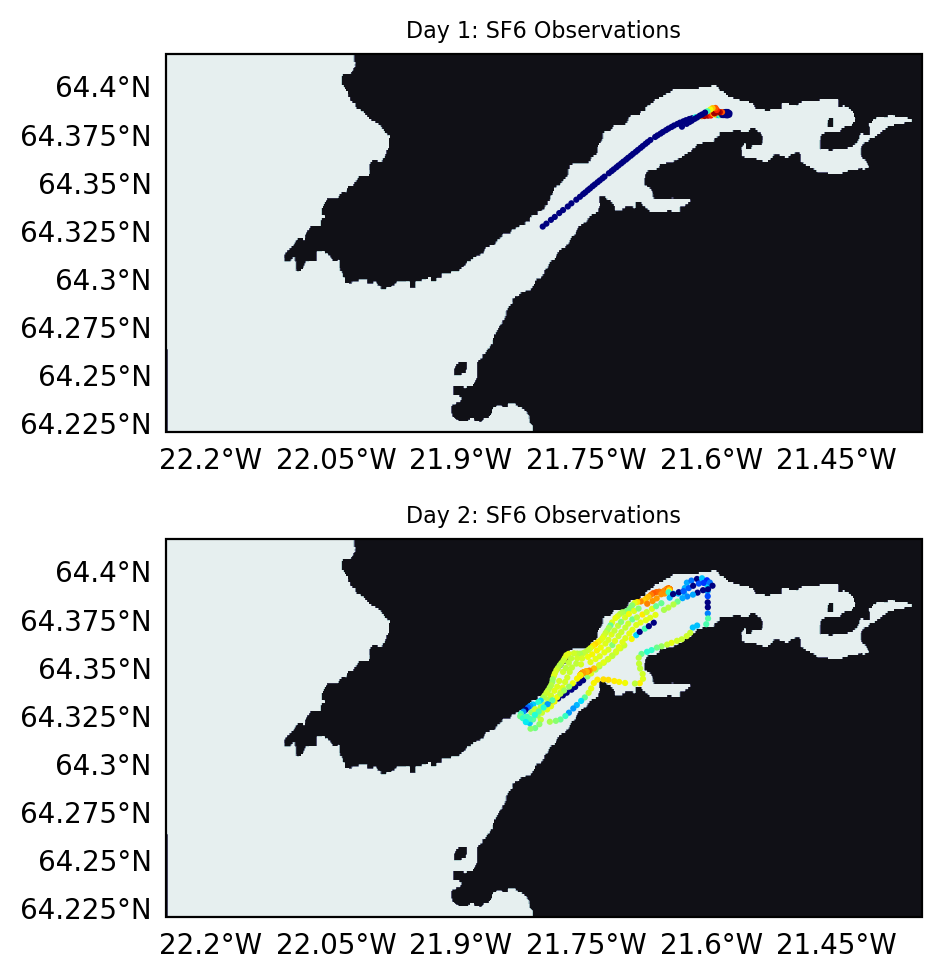

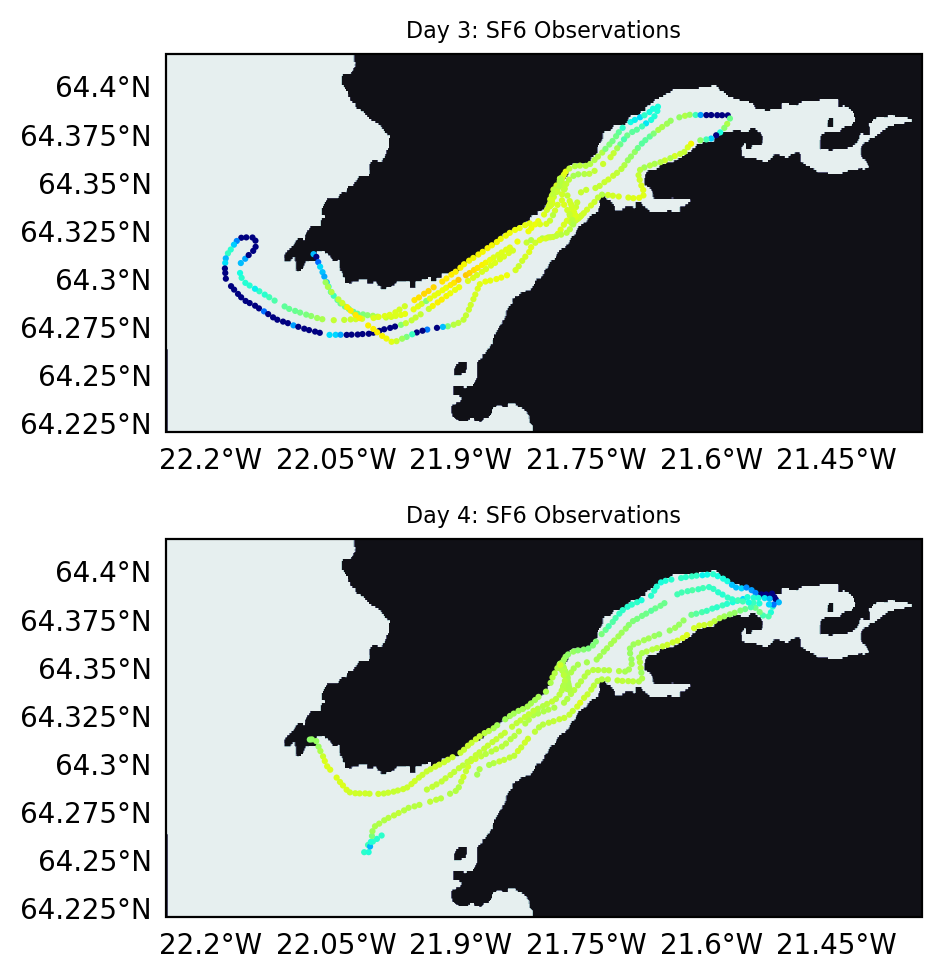

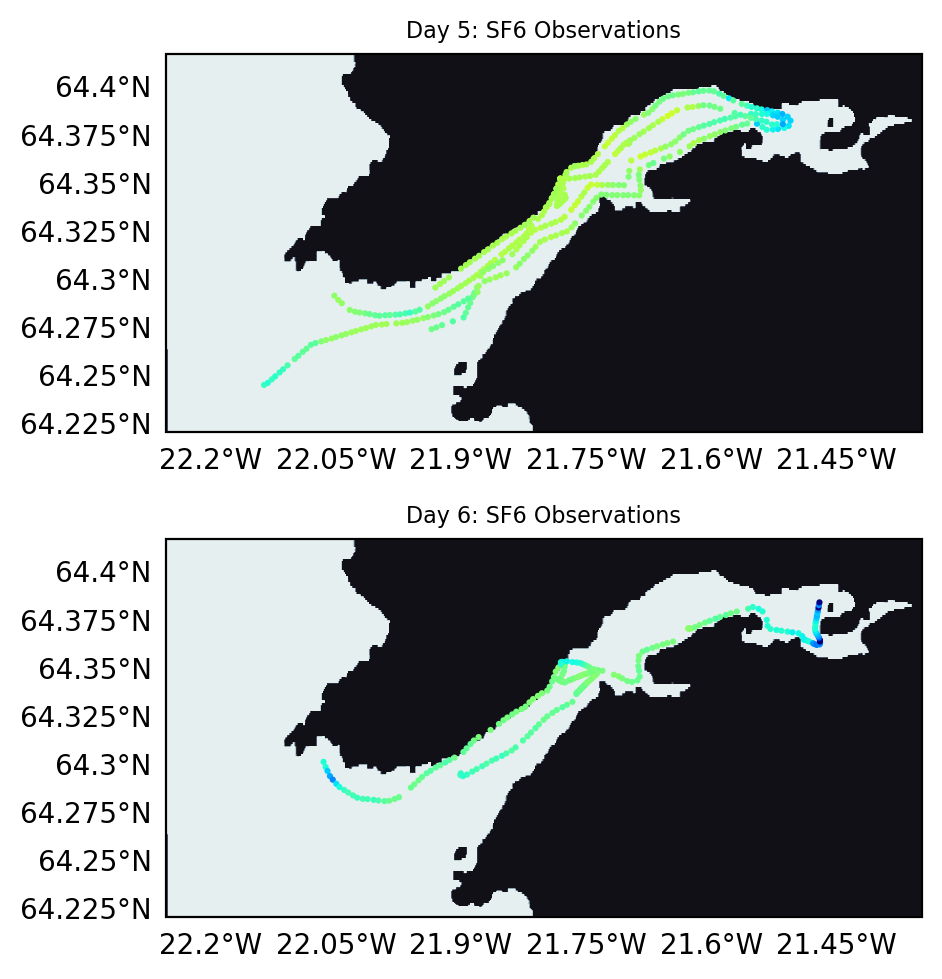

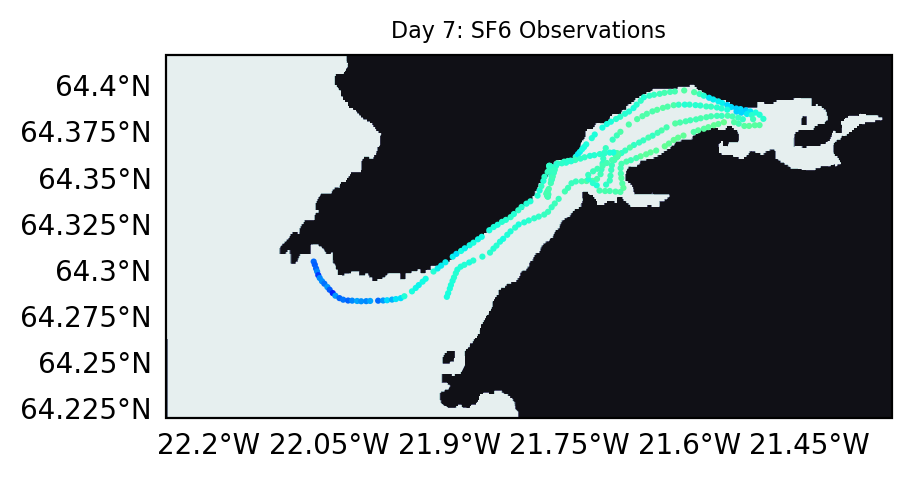

In [14]:
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

figures = [
    {'days': [0, 1]},       # Figure 1: Days 1–2
    {'days': [2, 3]},       # Figure 2: Days 3–4
    {'days': [4, 5]},       # Figure 3: Days 5–6
    {'days': [6]},          # Figure 4: Day 7
]

for fig_idx, group in enumerate(figures):
    nrows = len(group['days'])
    fig, axs = plt.subplots(nrows=nrows, figsize=(6, 2.5 * nrows), dpi=200,
                            subplot_kw={'projection': ccrs.Mercator()})

    if nrows == 1:
        axs = [axs]  # Make iterable if only one subplot

    for ax, day in zip(axs, group['days']):
        # Extract observation values
        obs_day = obs['SF6 (fmol/L)'].isel(Date=day).values
        obs_lat = obs['Lat'].isel(Date=day).values
        obs_lon = obs['Long'].isel(Date=day).values

        # Remove NaNs
        mask_valid = ~np.isnan(obs_day)
        obs_clear = obs_day[mask_valid]
        obs_lat = obs_lat[mask_valid]
        obs_lon = obs_lon[mask_valid]

        # Plot the land mask
        ax.contourf(mask.lon, mask.lat, mask.load(), transform=ccrs.PlateCarree(), cmap='bone')

        # Plot the observations as scatter points
        scatter = ax.scatter(obs_lon, obs_lat, c=obs_clear, cmap='jet', edgecolor='none',
                             transform=ccrs.PlateCarree(), s=5,
                             norm=LogNorm(vmin=1e-1, vmax=5e4))

        # Set map extent to match mask
        lon_min = float(mask.lon.min())
        lon_max = float(mask.lon.max())
        lat_min = float(mask.lat.min())
        lat_max = float(mask.lat.max())
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Add gridlines
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # Title
        ax.set_title(f'Day {day+1}: SF6 Observations', fontsize=8)

    # Optional colorbar for each figure (shared across subplots)
    # cbar = fig.colorbar(scatter, ax=axs, orientation='vertical', shrink=0.6, pad=0.05)
    # cbar.set_label('SF6 (fmol/L)')

    plt.tight_layout()
    plt.show()


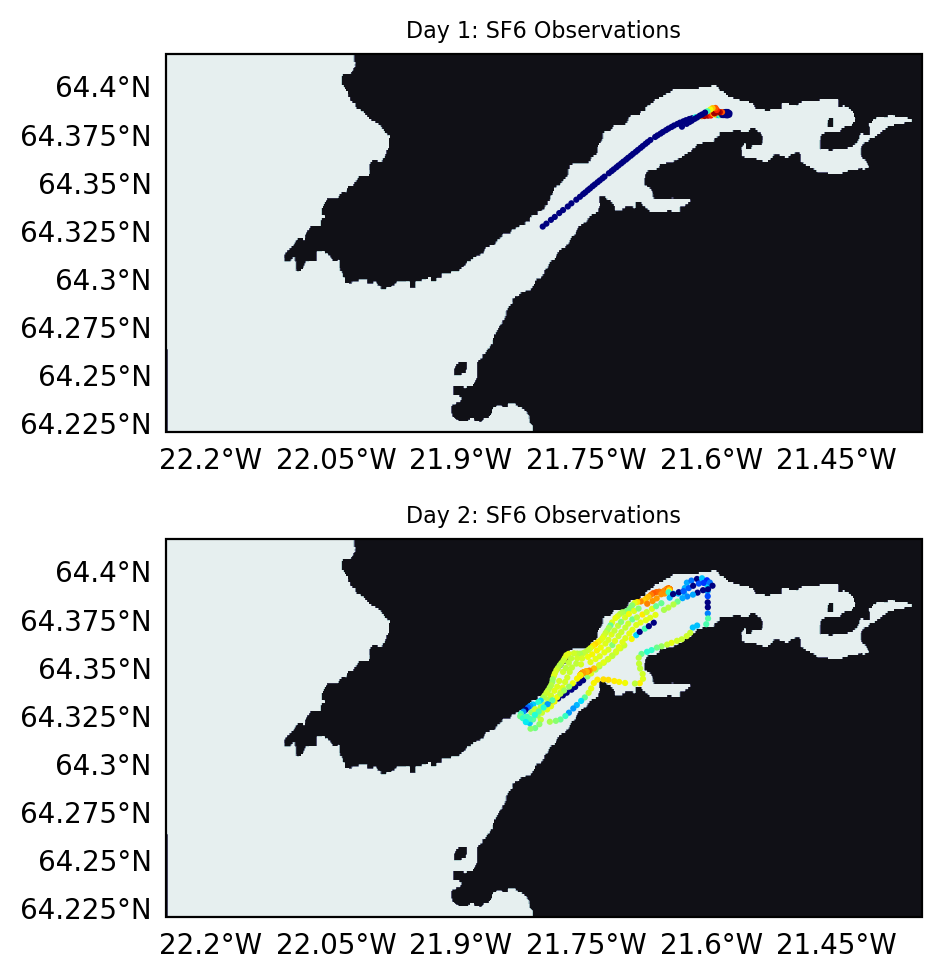

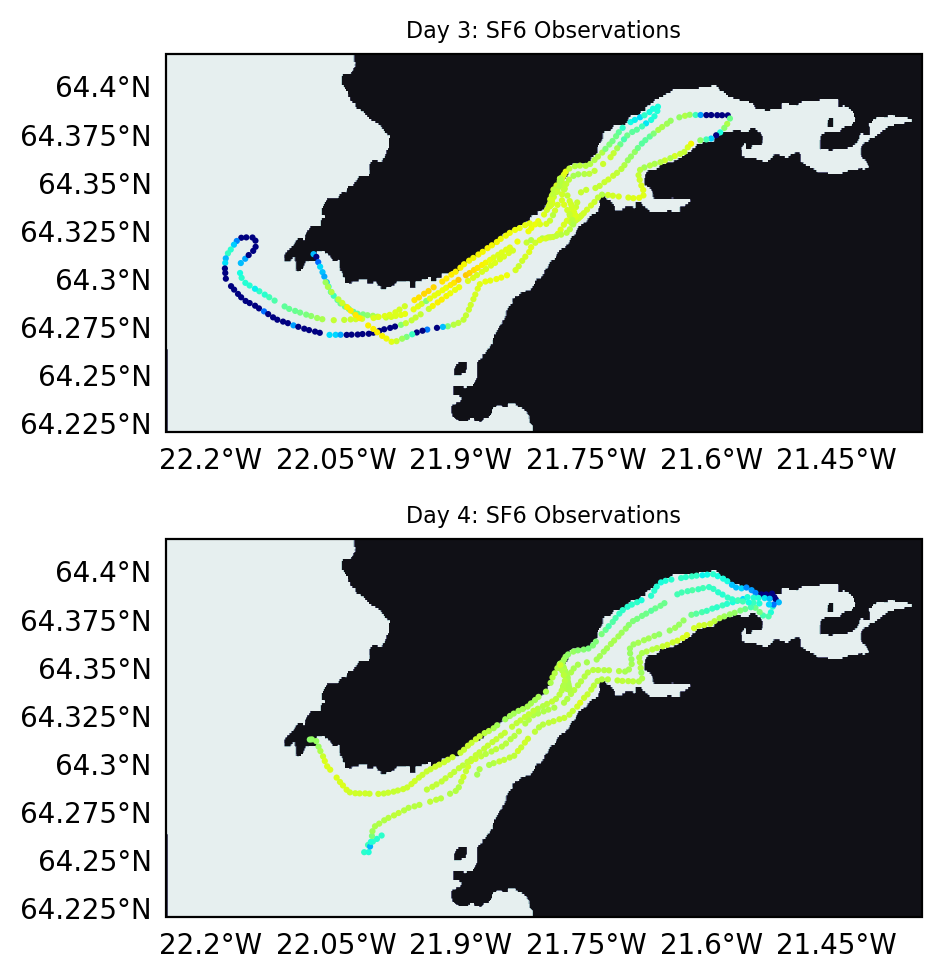

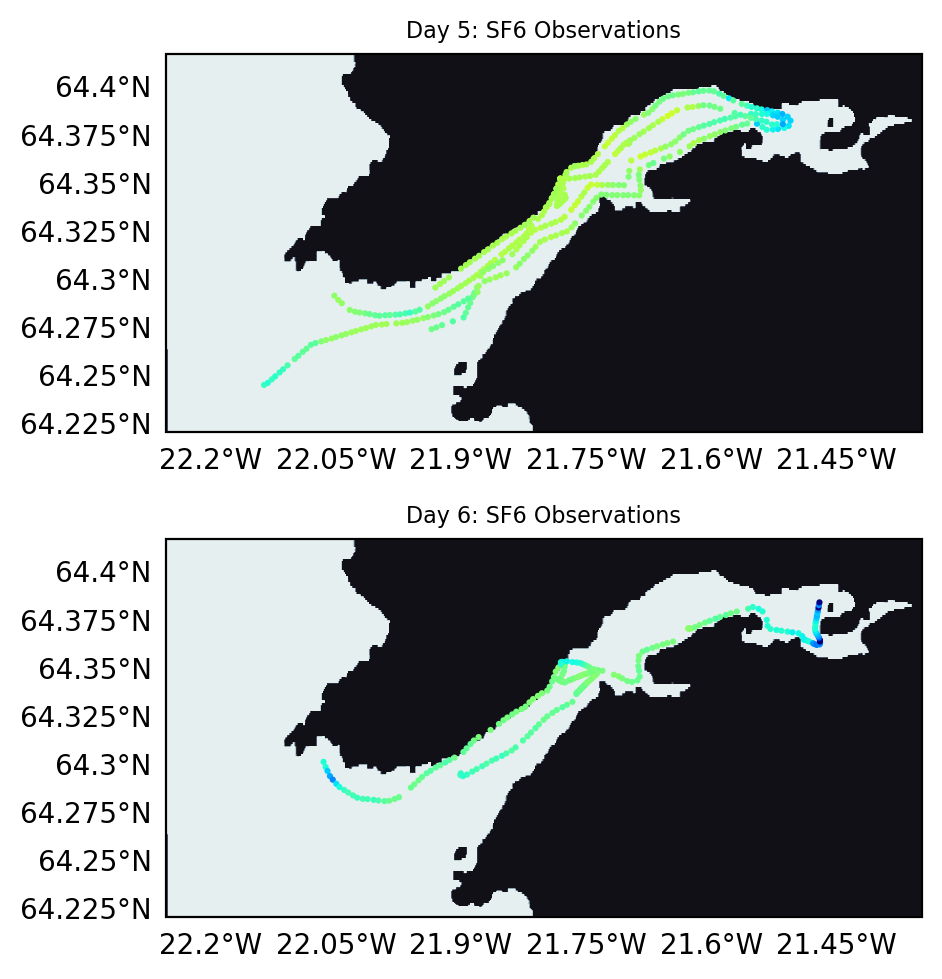

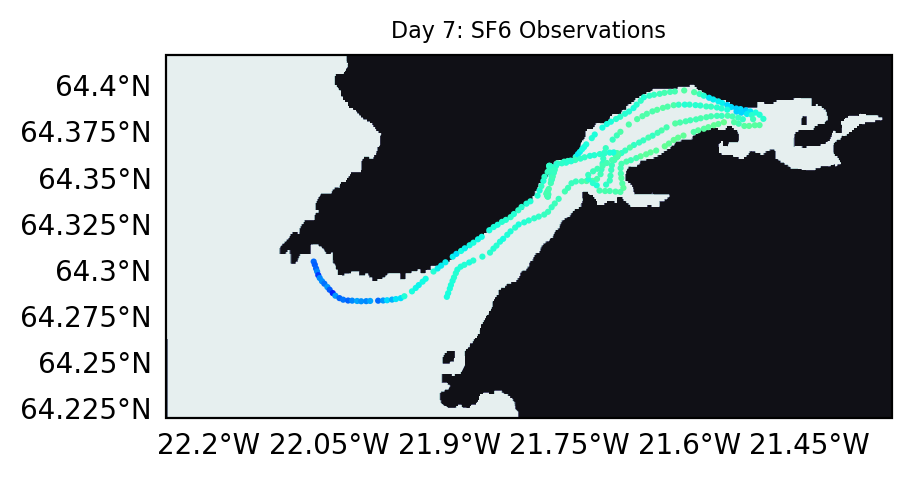

In [16]:
for fig_idx, group in enumerate(figures):
    nrows = len(group['days'])
    fig, axs = plt.subplots(nrows=nrows, figsize=(6, 2.5 * nrows), dpi=200,
                            subplot_kw={'projection': ccrs.Mercator()})

    if nrows == 1:
        axs = [axs]

    all_scatters = []
    for ax, day in zip(axs, group['days']):
        obs_day = obs['SF6 (fmol/L)'].isel(Date=day).values
        obs_lat = obs['Lat'].isel(Date=day).values
        obs_lon = obs['Long'].isel(Date=day).values

        mask_valid = ~np.isnan(obs_day)
        obs_clear = obs_day[mask_valid]
        obs_lat = obs_lat[mask_valid]
        obs_lon = obs_lon[mask_valid]

        ax.contourf(mask.lon, mask.lat, mask.load(), transform=ccrs.PlateCarree(), cmap='bone')

        scatter = ax.scatter(obs_lon, obs_lat, c=obs_clear, cmap='jet', edgecolor='none',
                             transform=ccrs.PlateCarree(), s=5,
                             norm=LogNorm(vmin=1e-1, vmax=5e4))
        all_scatters.append(scatter)

        lon_min = float(mask.lon.min())
        lon_max = float(mask.lon.max())
        lat_min = float(mask.lat.min())
        lat_max = float(mask.lat.max())
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Day {day+1}: SF6 Observations', fontsize=8)

    # Optional: add shared colorbar
    #cbar = fig.colorbar(all_scatters[0], ax=axs, orientation='vertical', shrink=0.6, pad=0.05)
    #cbar.set_label('SF6 (fmol/L)')

    plt.tight_layout()
    plt.savefig(f'sf6_obs_group_{fig_idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()


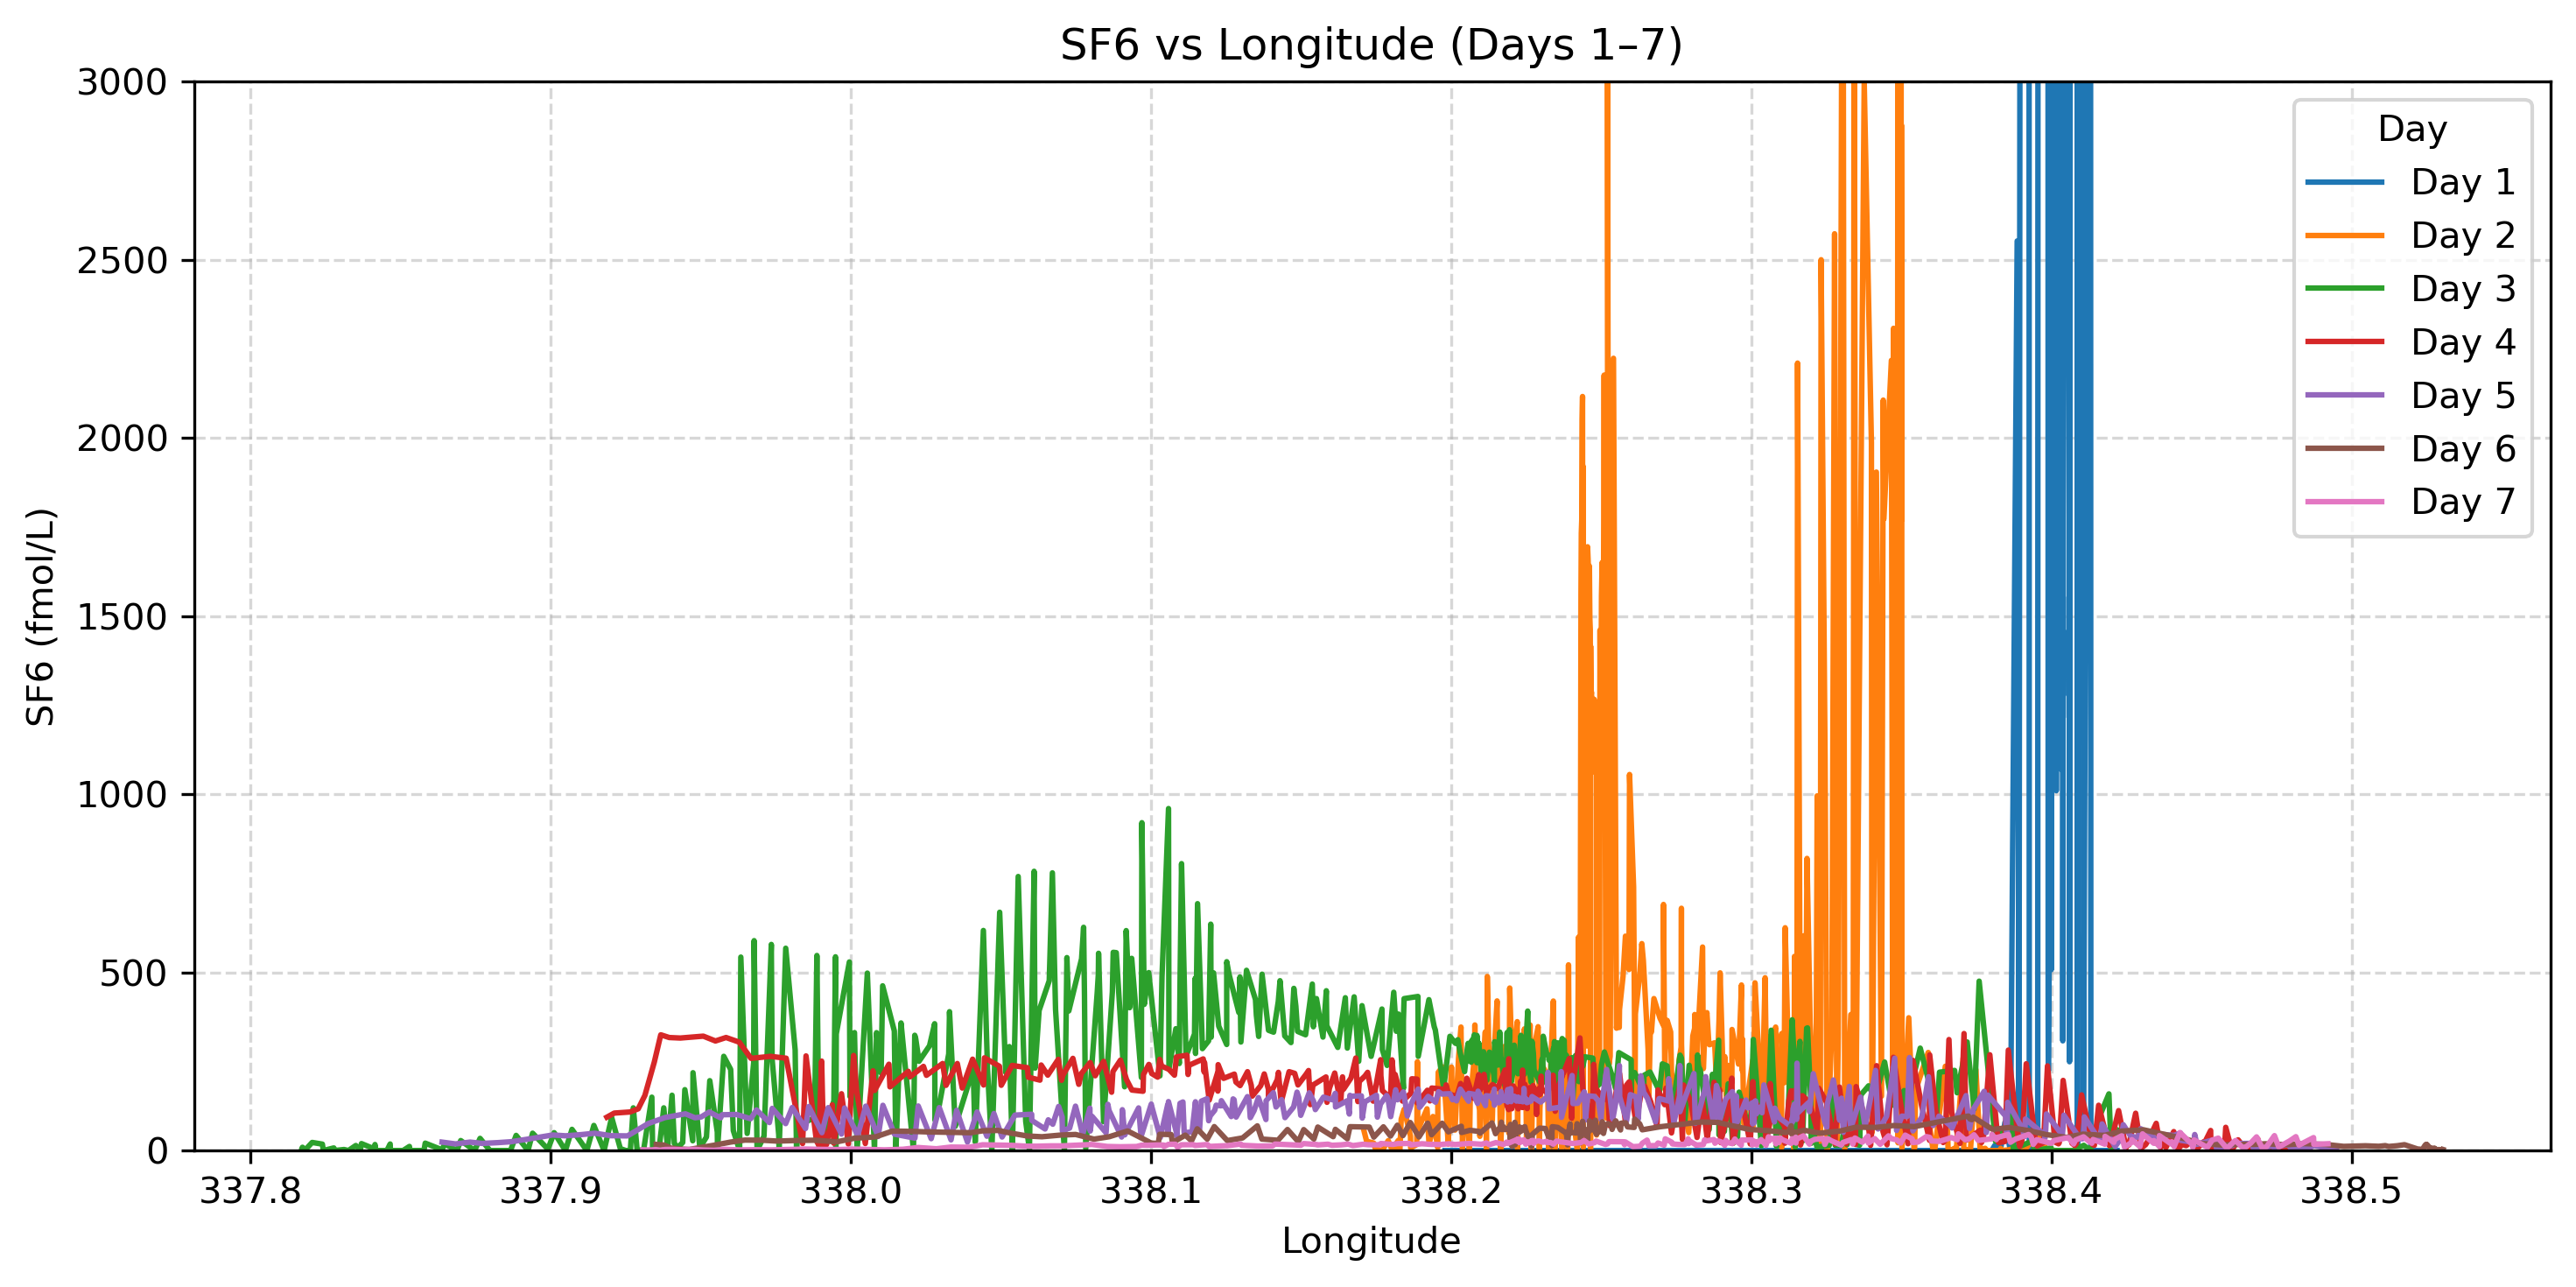

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr



num_days = 7

# Precompute the mask
mask = roms_regrid(grid, grid['mask_rho'])

# Set up plotting
plt.figure(figsize=(10, 5), dpi=300)
vmin, vmax = 1e-1, 5e4

for day in range(num_days):


    obs_day = obs['SF6 (fmol/L)'].isel(Date=day).values
    obs_lat = obs['Lat'].isel(Date=day).values
    obs_lon = obs['Long'].isel(Date=day).values

    mask_valid = ~np.isnan(obs_day)
    obs_clear = obs_day[mask_valid]
    obs_lat = obs_lat[mask_valid]
    obs_lon = obs_lon[mask_valid]

    # Convert to numpy arrays and sort by longitude
    lons = np.array(obs_lon)+360
    dye_values = np.array(obs_clear)
    sort_idx = np.argsort(lons)
    lons_sorted = lons[sort_idx]
    dye_sorted = dye_values[sort_idx]

    # Plot
    plt.plot(lons_sorted, dye_sorted, label=f'Day {day + 1}')

# Final plot formatting
#plt.yscale('log')
plt.xlabel('Longitude')
plt.ylabel('SF6 (fmol/L)')
plt.title('SF6 vs Longitude (Days 1–7)')
plt.legend(title='Day')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.ylim([0,3000])
plt.show()
